In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import forward_backward as fb
import gen_states_and_observation as gso
np.random.seed(12345)

In [3]:
#initialize paramaters
pi=np.array([.8,.2])
A = np.array([[.6, .4 ], [.2, .8]])
#B = np.array([[.9, .05, .05], [.05, .05, .9]])
B = np.array([[.2, .4, .4], [.5, .4, .1]])
Ntimes=5000


#initialize states and observations
Q, states, O, O_mat=gso.gen(pi,A,B,Ntimes)

#Q is the vector of states. 
#states is th matrix of states
#O is a vector of observations
#O_mat is the matrix of observations

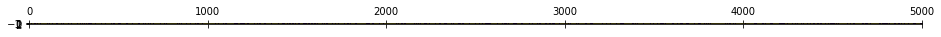

In [4]:
plt.matshow(states)

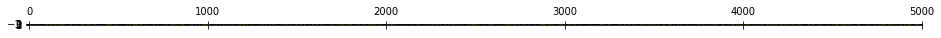

In [5]:
plt.matshow(O_mat)    

#Generate observations from the state
#do forward to due to the probabliities

# Run forward-backward to recover states (assuming $A$, $\pi$, $B$ known)

First, let's check against John's code:

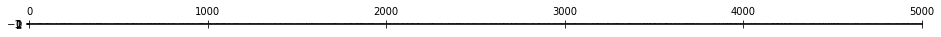

In [267]:
# make an array that's p(obs_t | z_t) for each possible z at each time (Ntimes x Nstates)
psi = np.array([B[:, o] for o in O])

post, logZ, Xi = fb.fb_infer(A.T, pi, psi)

plt.matshow(post.T)

In [268]:
# get intermediate quantitites from John's implementation

def john_setup(psi, A, pi):
    """
    Note: Uses John's conventions for A (i.e., columns sum to 1)
    """

    jv = dict()
    T = psi.shape[0]
    M = A.shape[0]
    jv['T'] = T
    jv['M'] = M

    # initialize empty variables
    jv['alpha'] = np.empty((jv['T'], M))  # p(z_t|y_{1:T})
    jv['beta'] = np.empty((T, M))  # p(y_{t+1:T}|z_t) (unnormalized)
    jv['gamma'] = np.empty((T, M))  # p(z_t|y_{1:T}) (posterior)
    jv['logZ'] = np.empty(T)  # log partition function
    jv['Xi'] = np.empty((T - 1, M, M))

    # initialize
    a = psi[0] * pi
    jv['a'] = a
    jv['alpha'][0] = a / np.sum(a)
    jv['logZ'][0] = np.log(np.sum(a))
    jv['beta'][-1, :] = 1
    jv['beta'][-1, :] = jv['beta'][-1, :] / np.sum(jv['beta'][-1, :])
    
    return jv

jv = john_setup(psi, A, pi)

fb.forward(psi, A.T, jv['alpha'], jv['logZ'], jv['a'])
fb.backward(psi, A.T, jv['beta'], jv['a'])
fb.calc_post(jv['alpha'], jv['beta'], jv['gamma'])

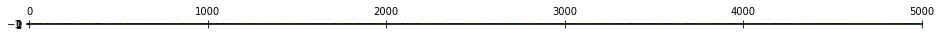

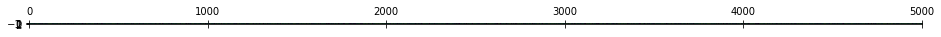

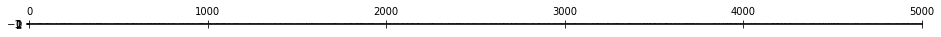

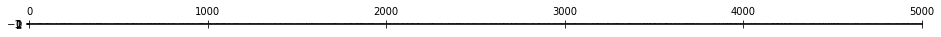

In [269]:
plt.matshow(jv['alpha'].T)
plt.matshow(jv['beta'].T)
plt.matshow(jv['gamma'].T)
plt.matshow(post.T)

In [270]:
def forward(O, A, B, pi):
    
    T = O.shape[0]
    
    N = A.shape[0]
    
    alpha = np.empty((N, T))# p(z_t|y_{1:T})
    alpha2 = np.empty((N, T))# p(z_t|y_{1:T})
    
    alpha[:,0]=pi*B[:,int(O[0])]
        
    alpha[:,0]=alpha[:,0]/sum(alpha[s,0] for s in range(N))
      
    for t in range(1,T):
        
        asum = sum([sum([alpha[j,t-1]*A[j,s]*B[s,int(O[t])]  for j in range(N)]) for s in range(N)])
        
        for s in range(N):
            
            alpha2[s,t]=sum([alpha[j,t-1]*A[j,s]*B[s,int(O[t])] for j in range(N)])
        
        alpha[:,t]=alpha2[:,t]   
        
        for s in range(N):
            
            alpha[s,t] =alpha[s,t]/asum
        
    forwardprob = np.sum(alpha,0)
        
    logZ = np.log(forwardprob)
    
    return forwardprob, alpha, logZ

In [271]:
def backward(O,A,B):
    T = O.shape[0]
    
    N = A.shape[0]
    
    beta = np.empty((N, T))# p(z_t|y_{1:T})
    beta2 = np.empty((N, T))# p(z_t|y_{1:T})
    beta[:,-1] = 1
            
    beta[:,-1] = beta[:,-1]/sum(beta[s,-1] for s in range(N))
       
    for t in range(T - 1, 0, -1):
        
        bsum=sum([sum([beta[j,t]*A[s,j]*B[j,int(O[t])] for j in range(N)]) for s in range(N)])
        
        for s in range(N):
            
            beta2[s,t-1]=sum([beta[j,t]*A[s,j]*B[j,int(O[t])] for j in range(N)])
            
        beta[:,t-1]=beta2[:,t-1] 
        
        for s in range(N):
            
            beta[s,t-1]=beta[s,t-1]/bsum
            
    backwardprob = np.sum(beta,0)
    
    return backwardprob, beta

In [272]:
def gamma_solver(alpha, beta):
    
    N, T= alpha.shape
    
    gamma = np.empty((N,T))
    
    for t in range(T):
        gamsum=0.0
        for s in range(N):
            
            gamma[s,t] = (alpha[s,t] * beta[s,t])
            
            gamsum +=gamma[s,t]
        
        for s in range(N):
            
            gamma[s,t] =gamma[s,t]/gamsum
     
    return gamma

In [273]:
forwardprob, alpha, logZ = forward(O, A, B, pi)

Text(0.5, 1.05, "John's alpha")

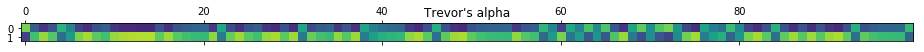

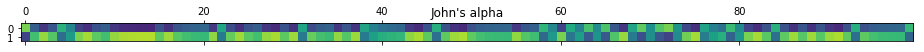

In [274]:
plt.matshow(alpha[:,0:100], vmin=0, vmax=1)
plt.title("Trevor's alpha")

plt.matshow(jv['alpha'].T[:,0:100], vmin=0, vmax=1)
plt.title("John's alpha")

In [275]:
backwardprob, beta = backward(O, A, B)

Text(0.5, 1.05, "John's beta")

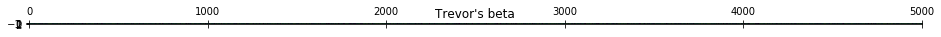

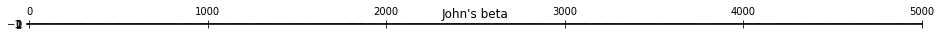

In [276]:
plt.matshow(beta)
plt.title("Trevor's beta")

plt.matshow(jv['beta'].T)
plt.title("John's beta")

In [277]:
gamma = gamma_solver(alpha, beta)

Text(0.5, 1.05, "John's gamma")

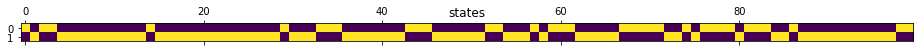

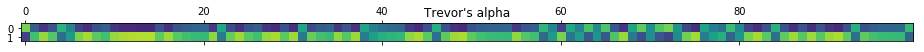

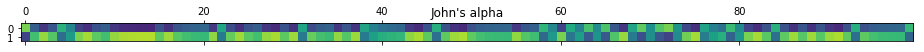

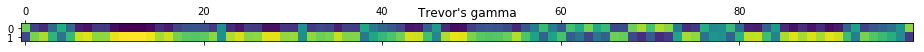

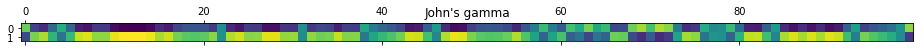

In [278]:
plt.matshow(states[:,0:100])
plt.title('states')

plt.matshow(alpha[:,0:100], vmin=0, vmax=1)
plt.title("Trevor's alpha")

plt.matshow(jv['alpha'].T[:,0:100], vmin=0, vmax=1)
plt.title("John's alpha")

plt.matshow(gamma[:,0:100])
plt.title("Trevor's gamma")

plt.matshow(jv['gamma'].T[:,0:100])
plt.title("John's gamma")

In [279]:
def delta_solver(alpha,beta,A_guess,B_guess):

    N, T = alpha.shape
    
    delta = np.empty((N,N,T-1))
    
    deltasum=0.0
    for t in range(T-1):
        deltasum=0.0
            
        for s in range(N):
            
            for j in range(N):
                
                delta[s,j,t]= alpha[s,t]*A_guess[s,j]*B_guess[j,int(O[t+1])]*beta[j,t+1]
                
                deltasum +=delta[s,j,t]
                
        for s in range(N):
            
            for j in range(N):
                
                delta[s,j,t]= delta[s,j,t]/deltasum     
        
    deltaprob = np.sum(delta,0)
    
    return delta

In [289]:
def EM(A_guess,B_guess,O,iterate,pi):
    
    err=np.zeros(iterate)
    
    err2=np.zeros(iterate)
    
    A_true = np.array([[.9, .1 ], [.2, .8]])
    
    B_true = np.array([[.2, .4, .4], [.5, .4, .1]])
    
    B_true = np.array([[.9, .05, .05], [.1, .2, .7]])
    
    N, Nobservations = B_guess.shape

    T = O.shape[0]
    
    for step in range(iterate): 
            
        forwardprob, alpha, logZ = forward(O,A_guess,B_guess, pi)
        
        #plt.matshow(alpha)

        backwardprob, beta = backward(O,A_guess,B_guess)

        gamma=gamma_solver(alpha,beta)

        delta=delta_solver(alpha,beta,A_guess,B_guess)

        
        for v in range(Nobservations):
            
            for j in range(N):
                
                B_guess[j,v]=sum([gamma[j,t] for t in range(T) if v==O[t]])/sum([gamma[j,t] for t in range(T)])
                
        for s in range(N):
            
            for j in range(N):
                
                A_guess[s,j]= sum(delta[s,j,t] for t in range(T-1))/sum(np.sum(delta[s,:,t]) for t in range(T-1))
                
        #print(A_guess)
                
                
            
    
        err[step]=np.linalg.norm(abs(A_true-A_guess))
        err2[step]=np.linalg.norm(abs(B_true-B_guess))
    
    A=A_guess
    B=B_guess
    
    return A, B, alpha, beta, gamma, forwardprob, err, err2, delta

Anew is [[0.90230461 0.09769539]
 [0.20215611 0.79784389]]
Bnew is [[0.9031972  0.05087429 0.0459285 ]
 [0.11555735 0.19608668 0.68835597]]


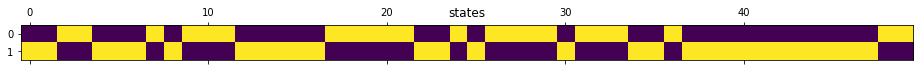

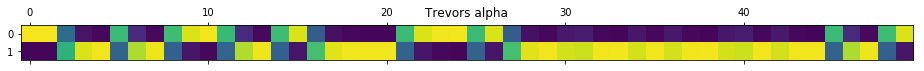

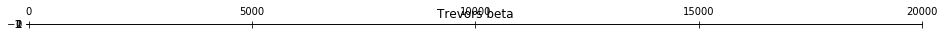

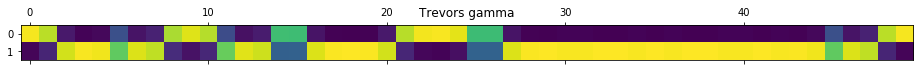

In [298]:
A = np.array([[.65, .35 ], [.1, .9]])  #incorrect guesses
B = np.array([[.7, .2, .1], [.1, .3, .6]]) #incorrect guesses

#A = np.array([[.6, .4 ], [.2, .8]]) #true guess
#B= np.array([[.9, .05, .05], [.05, .05, .9]])#true guess

pi=[.8,.2]


A_New, B_New, alpha4, beta4, gamma, forwardprob, errorA, errorB, delta2 =EM(A,B,O,20,pi)

plt.matshow(states[:,50:100])
plt.title('states')


plt.matshow(alpha4[:,50:100], vmin=0,vmax=1)
plt.title('Trevor''s alpha')
plt.matshow(beta4)
plt.title('Trevor''s beta')
plt.matshow(gamma[:,50:100], vmin=0, vmax=1)
plt.title('Trevor''s gamma')

print('Anew is', A_New)
print('Bnew is', B_New)

[[0.90119642 0.09880358]
 [0.20166565 0.79833435]]
[[0.90500293 0.05051049 0.04448658]
 [0.11909786 0.19549696 0.68540518]]


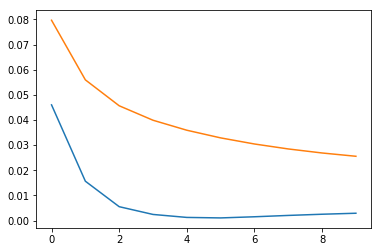

In [296]:
print(A_New)
print(B_New)
plt.plot(errorA)
plt.plot(errorB)

In [299]:
print(errorA)
print(errorB)

[0.04602159 0.01564573 0.00550937 0.00242025 0.0012359  0.00103877
 0.00149427 0.00203027 0.00250372 0.00290028 0.0032275  0.00349612
 0.00371619 0.00389632 0.0040437  0.00416424 0.00426282 0.00434342
 0.00440932 0.00446319]
[0.07969788 0.05597546 0.04566501 0.03990938 0.03593319 0.03288642
 0.03045413 0.02848312 0.0268776  0.0255676  0.02449819 0.02362507
 0.02291217 0.02233007 0.02185473 0.02146653 0.02114945 0.02089043
 0.02067882 0.02050591]


[[0.81478236 0.18521764]
 [0.38537773 0.61462227]]
0.9999999999999986
With inital guesses correct with 1000 EM-steps and 5000 timesteps


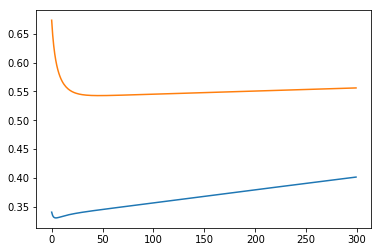

In [282]:
print(A_New)
print(np.sum(A_New[1,:]))
print('With inital guesses correct with 1000 EM-steps and 5000 timesteps')

plt.plot(errorA)
plt.plot(errorB)

With inital guesses correct with 1000 EM-steps and 5000 timesteps

[[0.59583964 0.40416036]
 [0.21005509 0.78994491]]
1.0000000000000009


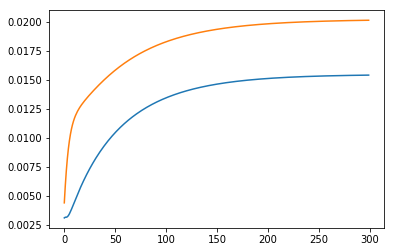

In [244]:
print(A_New)
print(np.sum(A_New[1,:]))


plt.plot(errorA)
plt.plot(errorB)

^^With inital guesses correct with 300 EM-steps and 5000 timesteps^^

with initial guesses incorrect, 300 EM-steps and 5000 timesteps

In [47]:
A = np.array([[.8, .2, ], [.3, .7]])
B = np.array([[.2, .4, .4], [.5, .4, .1]])
pi=[.8,.2]


A_New, B_New, alpha4, beta4, gamma, forwardprob, error =EM(A,B,O,20,pi)

plt.matshow(states)
plt.title('states')
plt.matshow(alpha4, vmin=0,vmax=1)
plt.title('Trevor''s alpha')
plt.matshow(beta4)
plt.title('Trevor''s beta')
plt.matshow(gamma, vmin=0, vmax=1)
plt.title('Trevor''s gamma')

print('Anew is', A_New)
print('Bnew is', B_New)

[[0.78450149 0.21549851]
 [0.29967178 0.70032822]]
[[0.81039979 0.18960021]
 [0.34812671 0.65187329]]
[[0.83740911 0.16259089]
 [0.40211005 0.59788995]]
[[0.86346125 0.13653875]
 [0.46115554 0.53884446]]
[[0.88755393 0.11244607]
 [0.52424639 0.47575361]]
[[0.90910118 0.09089882]
 [0.58940917 0.41059083]]
[[0.92776592 0.07223408]
 [0.65382278 0.34617722]]
[[0.9434294  0.0565706 ]
 [0.71432117 0.28567883]]
[[0.95618091 0.04381909]
 [0.7681208  0.2318792 ]]
[[0.96627757 0.03372243]
 [0.81340574 0.18659426]]
[[0.97407871 0.02592129]
 [0.84950226 0.15049774]]
[[0.97997902 0.02002098]
 [0.87665357 0.12334643]]
[[0.98435843 0.01564157]
 [0.89558951 0.10441049]]
[[0.98755337 0.01244663]
 [0.90707989 0.09292011]]
[[0.98984566 0.01015434]
 [0.91155716 0.08844284]]
[[0.99146284 0.00853716]
 [0.90880236 0.09119764]]
[[0.99258403 0.00741597]
 [0.89765147 0.10234853]]
[[0.99334723 0.00665277]
 [0.87572018 0.12427982]]
[[0.99385621 0.00614379]
 [0.83932655 0.16067345]]
[[0.99418796 0.00581204]
 [0.78

ValueError: too many values to unpack (expected 7)

In [143]:
print(sum(delta2[0,1,t] for t in range(1000)))
print(sum(np.sum(delta2[0,:,t]) for t in range(1000)) )

435/653

218.2747879955918
653.93186615648


0.666156202143951

In [28]:
A = np.array([[.6, .4, ], [.5, .5]])
B = np.array([[.2, .4, .4], [.5, .4, .1]])
pi=[.8,.2]
J_gamma, uh2, uh3= fb_infer(np.array(A).T,np.array(pi),np.array(B[:,O.astype(int)]).T)
plt.matshow(alpha4,vmin=0, vmax=1)
plt.title('Trevor''s alpha')
plt.matshow(beta4, vmin=0, vmax=1)
plt.title('Trevor''s beta')
plt.matshow(J_gamma.T, vmin=0, vmax=1)
plt.title('John''s gamma')
plt.matshow(gamma, vmin=0, vmax=1)
plt.title('Trevor''s gamma')



NameError: name 'fb_infer' is not defined

In [283]:
O=np.loadtxt('O')
Q=np.loadtxt('Q')

In [287]:
O

array([1., 2., 1., ..., 1., 2., 0.])

When I added v_min=0 and v_max=1 to your beta on the plot the distinction became more clear as to why alpha seems to dominate the gamma in your fb_infer. But I couldn't figure out why or how yours was different